<a href="https://colab.research.google.com/github/athabrani/DeepLearning/blob/main/IMDb_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_WORDS = 40000
MAXLEN = 400


# Load dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)
x_train = pad_sequences(x_train, maxlen=MAXLEN, padding='post')
x_test = pad_sequences(x_test, maxlen=MAXLEN, padding='post')

# Konversi ke tensor
x_train = torch.tensor(x_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


#RNN Model

In [17]:
class RNNModel(nn.Module):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(NUM_WORDS, 300, padding_idx=0)
        self.rnn = nn.RNN(300, 256, num_layers=3, batch_first=True, dropout=0.4, bidirectional=True)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(256 * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out.permute(0, 2, 1)
        out = self.pool(out).squeeze(2)
        return self.fc(out)


In [18]:
def train_model(model, train_loader, test_loader, epochs=10):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=2e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
    criterion = nn.BCELoss()

    train_losses, val_losses, accs = [], [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch).squeeze(1)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        train_losses.append(total_loss / len(train_loader))

        # Evaluate on test set
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output = model(x_batch).squeeze(1)
                val_loss += criterion(output, y_batch).item()
                preds = (output > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        accs.append(acc)
        val_losses.append(val_loss / len(test_loader))
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f} - Accuracy: {acc:.4f}")

    return train_losses, val_losses, accs, all_preds, all_labels

model = RNNModel()
train_losses, val_losses, accuracies, preds, targets = train_model(model, train_loader, test_loader, epochs=10)

Epoch 1/10 - Train Loss: 0.6924 - Val Loss: 0.6531 - Accuracy: 0.6462
Epoch 2/10 - Train Loss: 0.5862 - Val Loss: 0.5976 - Accuracy: 0.6942
Epoch 3/10 - Train Loss: 0.4757 - Val Loss: 0.4736 - Accuracy: 0.7820
Epoch 4/10 - Train Loss: 0.4019 - Val Loss: 0.4282 - Accuracy: 0.8042
Epoch 5/10 - Train Loss: 0.3410 - Val Loss: 0.4307 - Accuracy: 0.8034
Epoch 6/10 - Train Loss: 0.2998 - Val Loss: 0.3578 - Accuracy: 0.8402
Epoch 7/10 - Train Loss: 0.2620 - Val Loss: 0.3556 - Accuracy: 0.8431
Epoch 8/10 - Train Loss: 0.2273 - Val Loss: 0.3964 - Accuracy: 0.8354
Epoch 9/10 - Train Loss: 0.2038 - Val Loss: 0.4379 - Accuracy: 0.8283
Epoch 10/10 - Train Loss: 0.1794 - Val Loss: 0.4142 - Accuracy: 0.8363


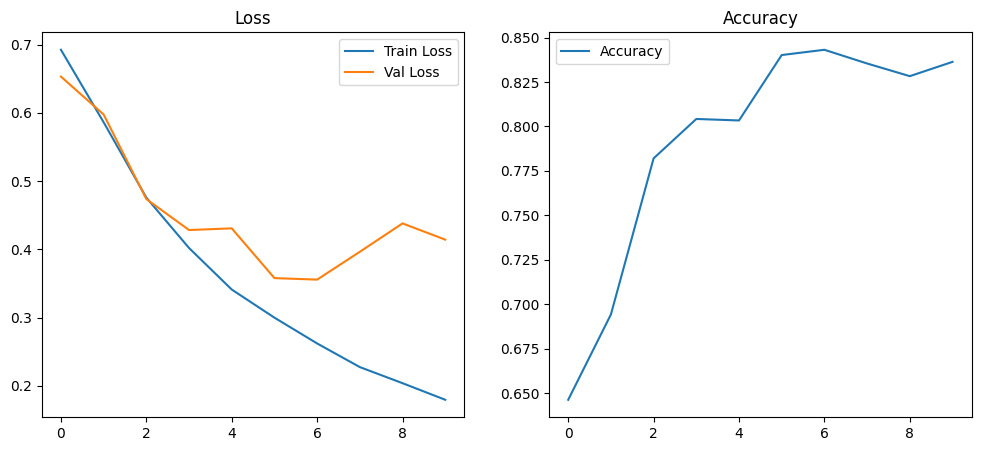

In [19]:
def plot_history(train_losses, val_losses, accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_history(train_losses, val_losses, accuracies)

Accuracy     : 0.8363
Precision    : 0.7796
Recall       : 0.9378
F1-Squared   : 0.8514
AUC          : 0.8363


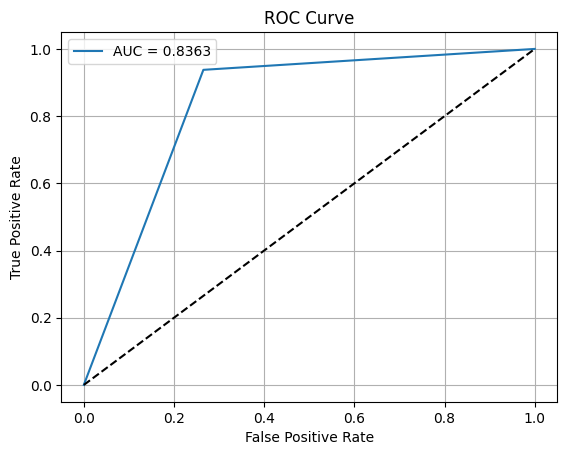

In [20]:

def evaluate_metrics(preds, targets):
    preds_binary = np.round(preds)
    acc = accuracy_score(targets, preds_binary)
    prec = precision_score(targets, preds_binary)
    rec = recall_score(targets, preds_binary)
    f1 = f1_score(targets, preds_binary)
    auc = roc_auc_score(targets, preds)

    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1-Squared   : {f1:.4f}")
    print(f"AUC          : {auc:.4f}")

    fpr, tpr, _ = roc_curve(targets, preds)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

evaluate_metrics(preds, targets)

#LSTM Model

In [22]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(NUM_WORDS, 300, padding_idx=0)
        self.lstm = nn.LSTM(300, 256, num_layers=3, batch_first=True, dropout=0.4, bidirectional=True)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(256 * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out = self.pool(out).squeeze(2)
        return self.fc(out)

In [23]:
def train_model(model, train_loader, test_loader, epochs=10):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=2e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
    criterion = nn.BCELoss()

    train_losses, val_losses, accs = [], [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch).squeeze(1)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        train_losses.append(total_loss / len(train_loader))

        # Evaluate on test set
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output = model(x_batch).squeeze(1)
                val_loss += criterion(output, y_batch).item()
                preds = (output > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        accs.append(acc)
        val_losses.append(val_loss / len(test_loader))
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f} - Accuracy: {acc:.4f}")

    return train_losses, val_losses, accs, all_preds, all_labels

model = LSTMModel()
train_losses, val_losses, accuracies, preds, targets = train_model(model, train_loader, test_loader, epochs=10)

Epoch 1/10 - Train Loss: 0.5751 - Val Loss: 0.4656 - Accuracy: 0.7874
Epoch 2/10 - Train Loss: 0.3805 - Val Loss: 0.3573 - Accuracy: 0.8415
Epoch 3/10 - Train Loss: 0.2941 - Val Loss: 0.3265 - Accuracy: 0.8597
Epoch 4/10 - Train Loss: 0.2569 - Val Loss: 0.3171 - Accuracy: 0.8680
Epoch 5/10 - Train Loss: 0.2085 - Val Loss: 0.3396 - Accuracy: 0.8695
Epoch 6/10 - Train Loss: 0.2000 - Val Loss: 0.3832 - Accuracy: 0.8609
Epoch 7/10 - Train Loss: 0.1442 - Val Loss: 0.3202 - Accuracy: 0.8769
Epoch 8/10 - Train Loss: 0.1251 - Val Loss: 0.3596 - Accuracy: 0.8781
Epoch 9/10 - Train Loss: 0.0948 - Val Loss: 0.3944 - Accuracy: 0.8716
Epoch 10/10 - Train Loss: 0.0782 - Val Loss: 0.4081 - Accuracy: 0.8788


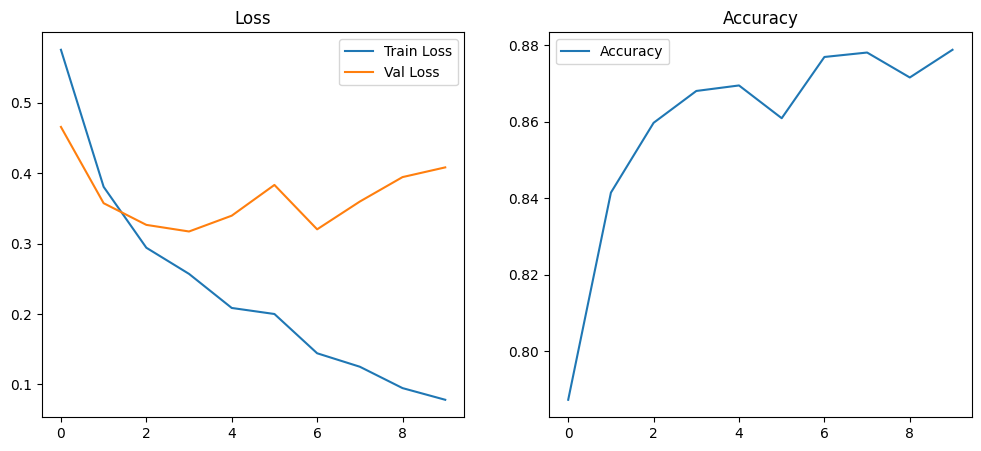

In [24]:
def plot_history(train_losses, val_losses, accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_history(train_losses, val_losses, accuracies)

Accuracy     : 0.8788
Precision    : 0.8638
Recall       : 0.8994
F1-Squared   : 0.8812
AUC          : 0.8788


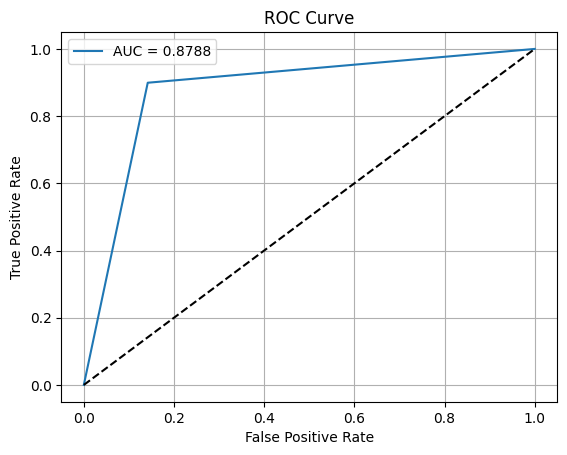

In [25]:

def evaluate_metrics(preds, targets):
    preds_binary = np.round(preds)
    acc = accuracy_score(targets, preds_binary)
    prec = precision_score(targets, preds_binary)
    rec = recall_score(targets, preds_binary)
    f1 = f1_score(targets, preds_binary)
    auc = roc_auc_score(targets, preds)

    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1-Squared   : {f1:.4f}")
    print(f"AUC          : {auc:.4f}")

    fpr, tpr, _ = roc_curve(targets, preds)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

evaluate_metrics(preds, targets)

#GRU Model

In [38]:
class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(NUM_WORDS, 300, padding_idx=0)
        self.gru = nn.GRU(300, 256, num_layers=3, batch_first=True, dropout=0.4, bidirectional=True)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(256 * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.gru(x)
        out = out.permute(0, 2, 1)
        out = self.pool(out).squeeze(2)
        return self.fc(out)

In [39]:
def train_model(model, train_loader, test_loader, epochs=10):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=2e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)
    criterion = nn.BCELoss()

    train_losses, val_losses, accs = [], [], []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch).squeeze(1)
            loss = criterion(output, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        train_losses.append(total_loss / len(train_loader))

        # Evaluate on test set
        model.eval()
        val_loss = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output = model(x_batch).squeeze(1)
                val_loss += criterion(output, y_batch).item()
                preds = (output > 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        accs.append(acc)
        val_losses.append(val_loss / len(test_loader))
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f} - Accuracy: {acc:.4f}")

    return train_losses, val_losses, accs, all_preds, all_labels

model = GRUModel()
train_losses, val_losses, accuracies, preds, targets = train_model(model, train_loader, test_loader, epochs=10)

Epoch 1/10 - Train Loss: 0.5774 - Val Loss: 0.4386 - Accuracy: 0.7977
Epoch 2/10 - Train Loss: 0.3743 - Val Loss: 0.3338 - Accuracy: 0.8558
Epoch 3/10 - Train Loss: 0.2850 - Val Loss: 0.3049 - Accuracy: 0.8695
Epoch 4/10 - Train Loss: 0.2286 - Val Loss: 0.3326 - Accuracy: 0.8586
Epoch 5/10 - Train Loss: 0.1833 - Val Loss: 0.2988 - Accuracy: 0.8840
Epoch 6/10 - Train Loss: 0.1510 - Val Loss: 0.3046 - Accuracy: 0.8831
Epoch 7/10 - Train Loss: 0.1201 - Val Loss: 0.3329 - Accuracy: 0.8830
Epoch 8/10 - Train Loss: 0.1001 - Val Loss: 0.3522 - Accuracy: 0.8814
Epoch 9/10 - Train Loss: 0.0722 - Val Loss: 0.3632 - Accuracy: 0.8846
Epoch 10/10 - Train Loss: 0.0570 - Val Loss: 0.4516 - Accuracy: 0.8822


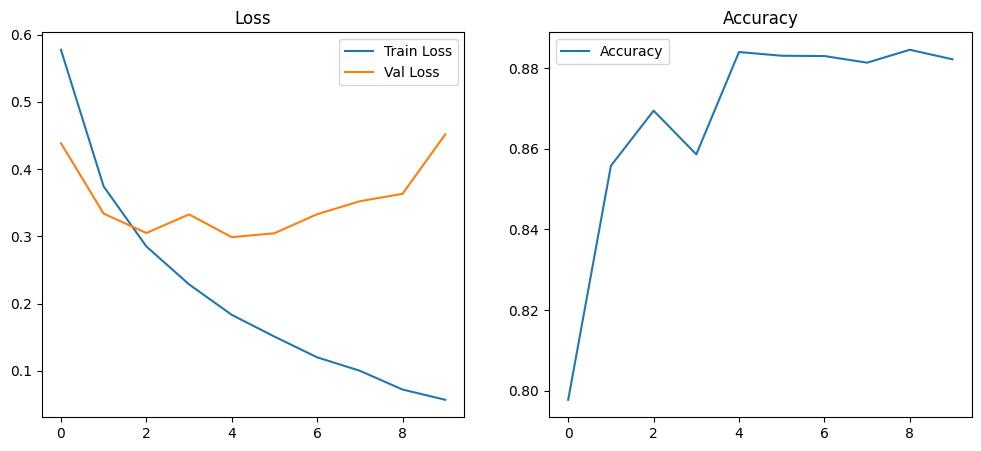

In [40]:
def plot_history(train_losses, val_losses, accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_history(train_losses, val_losses, accuracies)

Accuracy     : 0.8822
Precision    : 0.8552
Recall       : 0.9203
F1-Squared   : 0.8866
AUC          : 0.8822


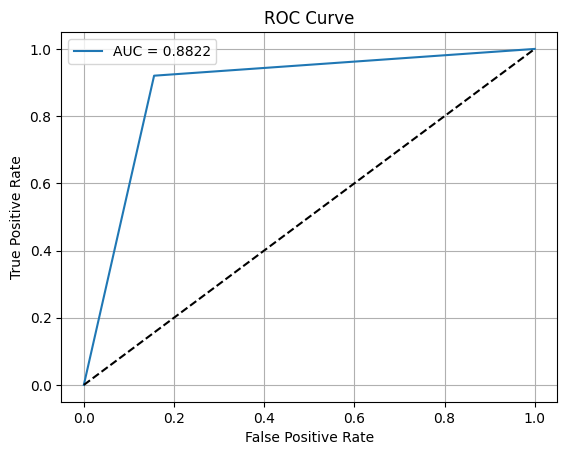

In [41]:

def evaluate_metrics(preds, targets):
    preds_binary = np.round(preds)
    acc = accuracy_score(targets, preds_binary)
    prec = precision_score(targets, preds_binary)
    rec = recall_score(targets, preds_binary)
    f1 = f1_score(targets, preds_binary)
    auc = roc_auc_score(targets, preds)

    print(f"Accuracy     : {acc:.4f}")
    print(f"Precision    : {prec:.4f}")
    print(f"Recall       : {rec:.4f}")
    print(f"F1-Squared   : {f1:.4f}")
    print(f"AUC          : {auc:.4f}")

    fpr, tpr, _ = roc_curve(targets, preds)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

evaluate_metrics(preds, targets)

# Sentiment Classification on IMDb Dataset using RNN, LSTM, and GRU with PyTorch

## Evaluation Result Comparison

| Model | Accuracy | Precision | Recall | F1 Score | AUC |
|-------|----------|-----------|--------|----------|-----|
| RNN   | 0.8363   | 0.7796    | 0.9378 | 0.8514   | 0.8363 |
| LSTM  | 0.8788   | 0.8638    | 0.8994 | 0.8812   | 0.8788 |
| GRU   | 0.8822   | 0.8552    | 0.9203 | 0.8866   | 0.8822 |

---


## 1. Mathematical Background

### 1.1 Binary Cross Entropy Loss (BCE)

Binary Cross Entropy digunakan untuk klasifikasi biner. Rumusnya:

$$
\text{BCE} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right]
$$

- \( y_i \) = label aktual (0 atau 1)
- \( \hat{y}_i \) = probabilitas prediksi model
- \( N \) = jumlah sampel

### 1.2 Precision

Precision mengukur ketepatan prediksi positif:

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

- TP = True Positives
- FP = False Positives

### 1.3 Recall

Recall mengukur seberapa baik model mendeteksi kelas positif:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

- FN = False Negatives

### 1.4 F1 Score

F1 Score adalah rata-rata harmonik dari precision dan recall:

$$
\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

### 1.5 AUC (Area Under Curve)

AUC mengukur kemampuan model dalam membedakan antara kelas. Semakin tinggi AUC, semakin baik model membedakan antara kelas 0 dan 1.

$$
\text{AUC} = \int_{0}^{1} TPR(FPR^{-1}(x)) dx
$$

### 1.6 ROC Curve (Receiver Operating Characteristic)

ROC adalah grafik yang menunjukkan trade-off antara:

- True Positive Rate (TPR) vs False Positive Rate (FPR)

$$
\text{TPR} = \frac{TP}{TP + FN}, \quad \text{FPR} = \frac{FP}{FP + TN}
$$

---

## 2. Recurrent Neural Networks (RNN, LSTM, GRU)

### 2.1 RNN (Recurrent Neural Network)

RNN memproses input secara sekuensial dan mempertahankan state tersembunyi \( h_t \):

$$
h_t = \tanh(W_{xh} x_t + W_{hh} h_{t-1} + b_h)
$$

$$
y_t = W_{hy} h_t + b_y
$$

Masalah utama RNN adalah **vanishing gradient**.

---

### 2.2 LSTM (Long Short-Term Memory)

LSTM mengatasi vanishing gradient dengan mekanisme *gate*.

$$
\begin{align*}
f_t &= \sigma(W_f [h_{t-1}, x_t] + b_f) \\
i_t &= \sigma(W_i [h_{t-1}, x_t] + b_i) \\
\tilde{C}_t &= \tanh(W_C [h_{t-1}, x_t] + b_C) \\
C_t &= f_t \ast C_{t-1} + i_t \ast \tilde{C}_t \\
o_t &= \sigma(W_o [h_{t-1}, x_t] + b_o) \\
h_t &= o_t \ast \tanh(C_t)
\end{align*}
$$

- \( f_t \) = forget gate
- \( i_t \) = input gate
- \( o_t \) = output gate
- \( C_t \) = cell state
- \( h_t \) = hidden state

---

### 2.3 GRU (Gated Recurrent Unit)

GRU adalah versi ringan dari LSTM:

$$
\begin{align*}
z_t &= \sigma(W_z [h_{t-1}, x_t]) \quad \text{(update gate)} \\
r_t &= \sigma(W_r [h_{t-1}, x_t]) \quad \text{(reset gate)} \\
\tilde{h}_t &= \tanh(W [r_t \ast h_{t-1}, x_t]) \\
h_t &= (1 - z_t) \ast h_{t-1} + z_t \ast \tilde{h}_t
\end{align*}
$$

- Lebih cepat dilatih daripada LSTM karena lebih sedikit parameter.

---





